This notebook is for fine-tuning a DeBERTa-v3-small model. It's reproducible if the PATHS class is set up correctly.

In [6]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download Data

In [8]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification
!yes | unzip jigsaw-unintended-bias-in-toxicity-classification.zip
!rm jigsaw-unintended-bias-in-toxicity-classification.zip

 98% 709M/723M [00:04<00:00, 162MB/s]
100% 723M/723M [00:04<00:00, 162MB/s]
Archive:  jigsaw-unintended-bias-in-toxicity-classification.zip
replace all_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: all_data.csv            
replace identity_individual_annotations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: identity_individual_annotations.csv  
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: test.csv                
replace test_private_expanded.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: test_private_expanded.csv  
replace test_public_expanded.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: test_public_expanded.csv  
replace toxicity_individual_annotations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: toxicity_individual_annotations.csv  
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflatin

In [9]:
!pip install datasets
!pip install scikit-multilearn

# Set up

In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
import warnings
import numpy as np, pandas as pd
import random
import torch
from skmultilearn.model_selection import iterative_train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter('ignore')

In [11]:
class PATHS:
    save = '/content/drive/MyDrive'
    fs = f'{save}/harm_v1/few_shot_labeled.tsv'
    sw = f'{save}/harm_v1/sw_labeled.tsv'
    ar = f'{save}/harm_v1/ar_labeled.tsv'
    arc = f'{save}/harm_v1/arc_labeled.tsv'
    toxic = f'{save}/harm_v1/toxic_labeled.tsv'
    ab = f'{save}/harm_v1/ab_labeled.tsv'
    toxic_train = 'train.csv'
    final_train = f'{save}/harm_train.tsv'
    final_test = f'{save}/harm_test.tsv'
    save_model_prep = f'{save}/harm-deberta-v3-small_prep'

In [12]:
class CFG:
    model_name = 'microsoft/deberta-v3-small'
    max_length = 512
    lr = 1e-5
    train_batch_size = 32
    train_epochs = 4
    weight_decay = 0.01
    warmup_ratio = 0.0
    labels = ['self_harm', 'harming_others', 'harmed_by_others','reference_to_harm']

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

# Load Positive Data

The positive data set consists of data sets with positive data for labels 'self_harm', 'harming_others', 'harmed_by_others', or 'reference_to_harm'. They consists of few shot data, suicide watch data, 0.9 toxic data, abusive relationship data, abusive relationship comments data, and all beauty data.

In [14]:
fs_df = pd.read_csv(PATHS.fs, sep='\t', dtype={'id': 'string'})
sw_df = pd.read_csv(PATHS.sw, sep='\t', dtype={'id': 'string'})
ar_df = pd.read_csv(PATHS.ar, sep='\t', dtype={'id': 'string'})
arc_df = pd.read_csv(PATHS.arc, sep='\t', dtype={'id': 'string'})
toxic_df = pd.read_csv(PATHS.toxic, sep='\t', dtype={'id': 'string'})
ab_df = pd.read_csv(PATHS.ab, sep='\t', dtype={'id': 'string'})
pos_dfs = [fs_df, sw_df, toxic_df, ar_df, arc_df, ab_df]
pos_names = ['few shot data', 'suicide watch data',  '0.9 toxic data', 'abusive relationship data', 'abusive relationship comments data', 'all beauty dataset']
pos_df = pd.concat(pos_dfs)

In [15]:
for df, name in zip(pos_dfs, pos_names):
    print(f"Numer of samples in {name} = {len(df)}")

Numer of samples in few shot data = 64
Numer of samples in suicide watch data = 5561
Numer of samples in 0.9 toxic data = 9226
Numer of samples in abusive relationship data = 9502
Numer of samples in abusive relationship comments data = 7495
Numer of samples in all beauty dataset = 5371


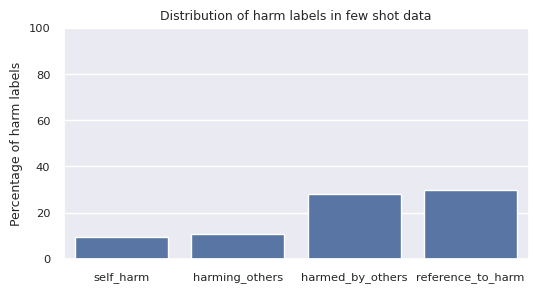

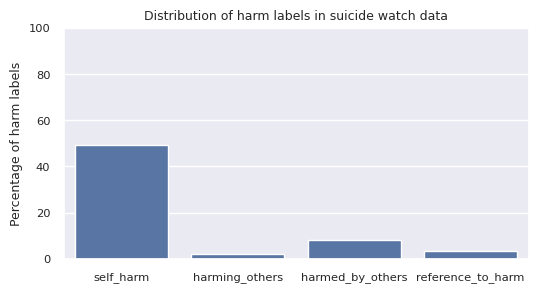

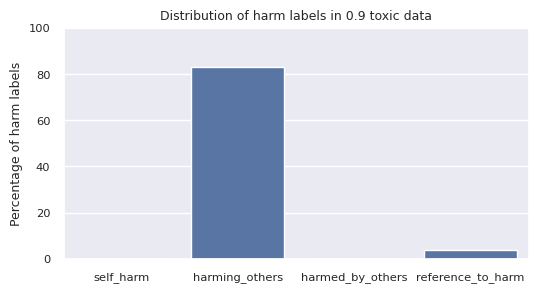

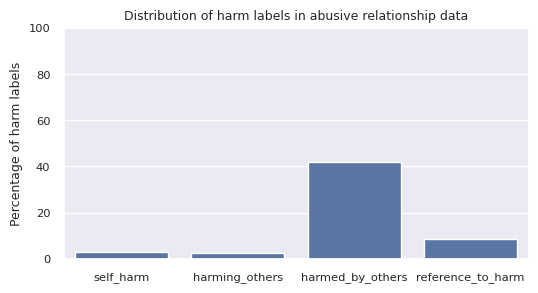

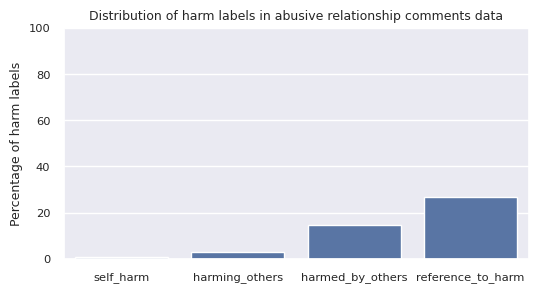

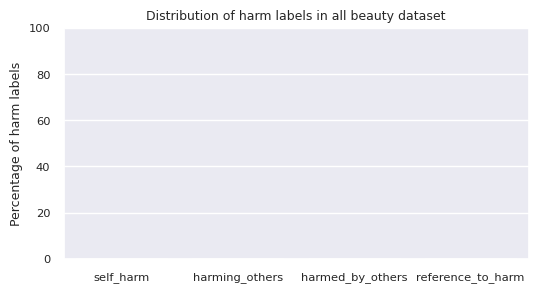

In [16]:
sns.set(font_scale=0.75)
for df, name in zip(pos_dfs, pos_names):
    plt.figure(figsize=(6, 3))
    plt.ylim(0, 100)
    plt.title(f"Distribution of harm labels in {name}")
    sns.barplot(x=CFG.labels, y=[sum(df[label] == 1)/len(df) * 100 for label in CFG.labels])
    plt.ylabel("Percentage of harm labels")

Summary of positive data

In [17]:
print(f"Number of total no harm = {sum((pos_df['self_harm'] == 0) & (pos_df['harming_others'] == 0) & (pos_df['harmed_by_others'] == 0) & (pos_df['reference_to_harm'] == 0))}")
for label in CFG.labels:
    print(f"Number of total {label} = {sum(pos_df[label] == 1)}")

Number of total no harm = 17799
Number of total self_harm = 3125
Number of total harming_others = 8305
Number of total harmed_by_others = 5585
Number of total reference_to_harm = 3402


Text(0, 0.5, 'Percentage of harm labels')

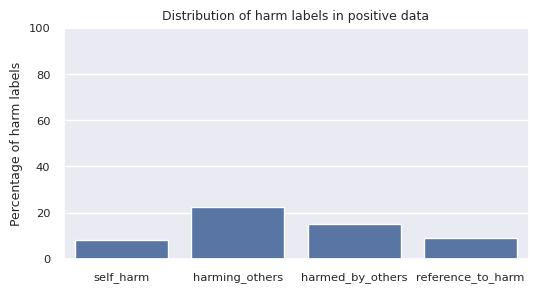

In [18]:
sns.set(font_scale=0.75)
plt.figure(figsize=(6, 3))
plt.ylim(0, 100)
plt.title(f"Distribution of harm labels in positive data")
sns.barplot(x=CFG.labels, y=[sum(pos_df[label] == 1)/len(pos_df) * 100 for label in CFG.labels])
plt.ylabel("Percentage of harm labels")

# Load Negative Data

The negative data set consists of data with 0 'toxicity' from the toxic data set. Even though I'd like to label them 0 in all harm labels, some of them have positive 'harmed_by_others' or 'reference_to_harm'. I go through a filtering process to remove them.

In [ ]:
toxic_train_df = pd.read_csv(PATHS.toxic_train, dtype={'id': 'string'})

In [ ]:
neg_df = toxic_train_df.loc[toxic_train_df['target'] == 0].dropna()
neg_df = neg_df.rename(columns={'comment_text': 'text'})[['id', 'text']]
neg_df['text'] = neg_df['text'].str.replace('\n', ' ')
neg_df[CFG.labels] = [0, 0, 0, 0]

In [ ]:
train_df = pd.concat([pos_df, neg_df])

# Train Test Split

In [ ]:
X = train_df
y = train_df[CFG.labels]

In [ ]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.1)

In [ ]:
train = pd.DataFrame(X_train, columns=(['id', 'text']+CFG.labels))
test = pd.DataFrame(X_test, columns=(['id', 'text']+CFG.labels))

# Tokenize Prep Train

pos_train are the part of the training split that belong to the original positive data. In other words, they're what's left after I remove the negative data from the train split. I carry out a "prep training" based on this smaller set pos_train, and use this "prep training" model to filter out the negative data with harm labels.

In [ ]:
pos_train = train[train['id'].isin(pos_df['id'])]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

In [ ]:
def tokenize_function(batch):
    tokenized_inputs = tokenizer(
        batch['text'],
        padding=True,
        truncation=True,
        max_length=CFG.max_length,
    )
    batch_labels = {label: batch[label] for label in CFG.labels}
    matrix_labels = np.zeros((len(batch['text']), len(CFG.labels)))
    for i, label in enumerate(CFG.labels):
        matrix_labels[:, i] = batch_labels[label]
    tokenized_inputs['labels'] = matrix_labels
    return tokenized_inputs

In [ ]:
pos_train_dict = {}
for col in ['id', 'text'] + CFG.labels:
    pos_train_dict[col] = pos_train[col].tolist()

In [ ]:
pos_train_ds = Dataset.from_dict(pos_train_dict)
tokenized_pos_train_ds = pos_train_ds.map(tokenize_function, batched=True)
tokenized_pos_train_ds.set_format('torch')

Map:   0%|          | 0/35275 [00:00<?, ? examples/s]

In [ ]:
id2label = {i: label for i, label in enumerate(CFG.labels)}
label2id = {label: i for i, label in enumerate(CFG.labels)}

# Prep Training

In [ ]:
config = AutoConfig.from_pretrained(CFG.model_name)
config.num_labels = len(CFG.labels)
config.problem_type = 'multi_label_classification'
config.id2label = id2label
config.label2id = label2id
model = AutoModelForSequenceClassification.from_pretrained(CFG.model_name, config=config)
model.resize_token_embeddings(len(tokenizer))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(128001, 768, padding_idx=0)

In [ ]:
training_args = TrainingArguments(
    output_dir='output',
    fp16=True,
    learning_rate=CFG.lr,
    per_device_train_batch_size=CFG.train_batch_size,
    num_train_epochs=CFG.train_epochs,
    weight_decay=CFG.weight_decay,
    save_strategy='epoch',
    save_total_limit=1,
    report_to='none',
    warmup_ratio=CFG.warmup_ratio,
    lr_scheduler_type='linear',
    optim='adamw_torch',
    logging_first_step=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_pos_train_ds,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

Step,Training Loss
1,0.680300
500,0.253500
1000,0.144400
1500,0.122400
2000,0.118000
2500,0.106600
3000,0.102300
3500,0.095900
4000,0.089400


TrainOutput(global_step=4412, training_loss=0.12554792207365995, metrics={'train_runtime': 4584.1304, 'train_samples_per_second': 30.78, 'train_steps_per_second': 0.962, 'total_flos': 1.86924824039424e+16, 'train_loss': 0.12554792207365995, 'epoch': 4.0})

In [ ]:
trainer.save_model(PATHS.save_model_prep)

# Inference on the Negative Data




We run inference on the negative data using the "prep training" model, and filter out the data with harm labels.

In [ ]:
sigmoid = torch.nn.Sigmoid()

In [ ]:
neg_dict = {}
for col in ['id', 'text'] + CFG.labels:
    neg_dict[col] = neg_df[col].tolist()

In [ ]:
neg_ds = Dataset.from_dict(neg_dict)
tokenized_neg_ds = neg_ds.map(tokenize_function, batched=True)
tokenized_neg_ds.set_format('torch')

Map:   0%|          | 0/144210 [00:00<?, ? examples/s]

In [ ]:
neg_pred = trainer.predict(tokenized_neg_ds)

In [ ]:
neg_proba = sigmoid(torch.Tensor(neg_pred.predictions)).numpy()
neg_pred = np.where(neg_proba >= 0.5, 1, 0)

In [ ]:
neg_df[[label+'_pred' for label in CFG.labels]] = neg_pred
mask = ( (neg_df['self_harm'] != neg_df['self_harm_pred']) | (neg_df['harming_others'] != neg_df['harming_others_pred']) |
         (neg_df['harmed_by_others'] != neg_df['harmed_by_others_pred']) | (neg_df['reference_to_harm'] != neg_df['reference_to_harm_pred']) )

In [ ]:
neg_drop_df = neg_df[mask]
train = train[~train['id'].isin(neg_drop_df['id'])]
test = test[~test['id'].isin(neg_drop_df['id'])]

Write filtered training and test

In [ ]:
for label in CFG.labels:
    print(f"{label}: positives in training = {sum(train[label] == 1)}, positives in test = {sum(test[label] == 1)}")

self_harm: positives in training = 2813, positives in test = 312
harming_others: positives in training = 7475, positives in test = 830
harmed_by_others: positives in training = 5027, positives in test = 558
reference_to_harm: positives in training = 3062, positives in test = 340


In [ ]:
train.to_csv(PATHS.final_train, sep='\t', index=False)
test.to_csv(PATHS.final_test, sep='\t', index=False)

In [ ]:
print(len(train), len(test))

132485 14266
